In [59]:
#Import the libraries
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import math
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [60]:
#Read the csv file
booking_df=pd.read_csv("hotel_bookings.csv")
booking_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [61]:
#Check the no. of NaN in all the columns
booking_df.isna().sum().sort_values(ascending=False)

company                           112593
agent                              16340
country                              488
children                               4
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
hotel                                  0
previous_cancellations                 0
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
previous_bookings_not_canceled         0
is_repeated_guest                      0
is_canceled                            0
distribution_channel                   0
market_segment                         0
meal                                   0
babies                                 0
adults                                 0
stays_in_week_ni

In [62]:
#Replace the NaN values with mean and mode
booking_df['agent'].fillna(round(booking_df.agent.mean()),inplace=True)
booking_df['children'].fillna(round(booking_df.children.mean()),inplace=True)
booking_df['company'].fillna(round(booking_df.company.mean()),inplace=True)
booking_df['country'].fillna(round(booking_df.company.mode()),inplace=True)

In [63]:
#Create a new df to work with
booking_df_drop=booking_df.copy()

In [64]:
#EDA

def plot(x, y, x_label=None,y_label=None, title=None, figsize=(10,5), type=None):
    sns.set_style('whitegrid')
    
    fig, ax = plt.subplots(figsize=figsize)
    if x_label != None:
        ax.set_xlabel(x_label)
    if y_label != None:
        ax.set_ylabel(y_label)
    if title != None:
        ax.set_title(title)
    if type == 'bar':
        sns.barplot(x=x,y=y, ax = ax)
    elif type == 'line':
        sns.lineplot(x=x,y=y, ax = ax)
    plt.show()

def get_count(ser, limit=None):

    if limit != None:
        ser = ser.value_counts()[:limit]
    else:
        ser = ser.value_counts()
    
    x = ser.index
    y = ser/ser.sum()*100
    
    return x.values,y.values

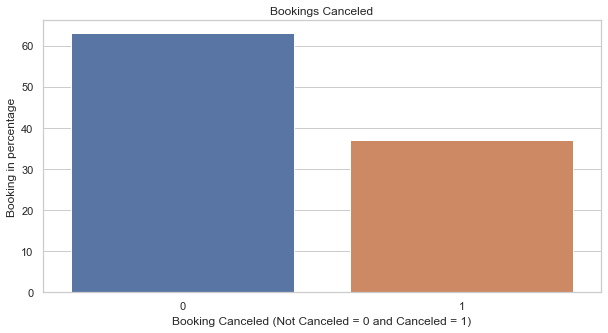

In [65]:
#How many booking were cancelled?

x,y=get_count(booking_df_drop['is_canceled'])
plot(x,y,x_label='Booking Canceled (Not Canceled = 0 and Canceled = 1)',y_label='Booking in percentage',title='Bookings Canceled',type='bar')

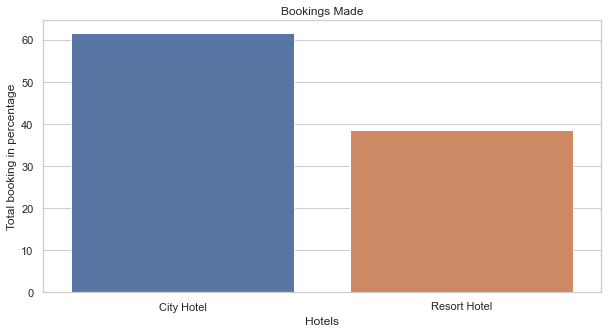

In [66]:
#Booking ratio

df_not_canceled=booking_df_drop[booking_df_drop['is_canceled']==0]
df_not_canceled

x,y= get_count(df_not_canceled['hotel'])
plot(x,y,x_label='Hotels',y_label='Total booking in percentage',title='Bookings Made',type='bar')

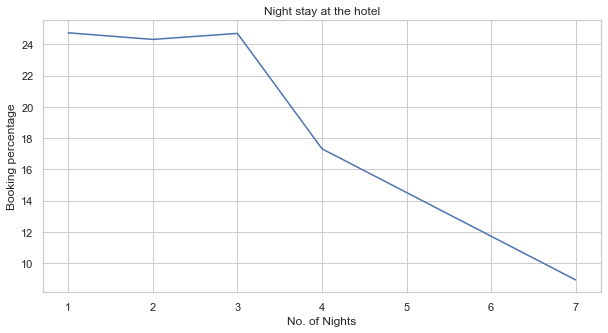

In [67]:
#How long does a customer stay in a hotel?

total_nights=df_not_canceled['stays_in_weekend_nights']+df_not_canceled['stays_in_week_nights']
x,y=get_count(total_nights,limit=5)

plot(x,y,x_label='No. of Nights',y_label='Booking percentage',title='Night stay at the hotel',figsize=(10,5),type='line')

In [68]:
#Label encode the categorical variables

le=LabelEncoder()
cols = ['hotel','market_segment', 'meal', 'country','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type','reservation_status','reservation_status_date']
booking_df_drop[cols] = booking_df_drop[cols].apply(le.fit_transform)
booking_df_drop.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,0,342,2015,July,27,1,0,0,2,...,0,87.0,189.0,0,2,0.0,0,0,1,121
1,1,0,737,2015,July,27,1,0,0,2,...,0,87.0,189.0,0,2,0.0,0,0,1,121
2,1,0,7,2015,July,27,1,0,1,1,...,0,87.0,189.0,0,2,75.0,0,0,1,122
3,1,0,13,2015,July,27,1,0,1,1,...,0,304.0,189.0,0,2,75.0,0,0,1,122
4,1,0,14,2015,July,27,1,0,2,2,...,0,240.0,189.0,0,2,98.0,0,1,1,123


[Text(0.5, 0, 'hotel'),
 Text(1.5, 0, 'is_canceled'),
 Text(2.5, 0, 'lead_time'),
 Text(3.5, 0, 'arrival_date_year'),
 Text(4.5, 0, 'arrival_date_week_number'),
 Text(5.5, 0, 'arrival_date_day_of_month'),
 Text(6.5, 0, 'stays_in_weekend_nights'),
 Text(7.5, 0, 'stays_in_week_nights'),
 Text(8.5, 0, 'adults'),
 Text(9.5, 0, 'children'),
 Text(10.5, 0, 'babies'),
 Text(11.5, 0, 'meal'),
 Text(12.5, 0, 'country'),
 Text(13.5, 0, 'market_segment'),
 Text(14.5, 0, 'distribution_channel'),
 Text(15.5, 0, 'is_repeated_guest'),
 Text(16.5, 0, 'previous_cancellations'),
 Text(17.5, 0, 'previous_bookings_not_canceled'),
 Text(18.5, 0, 'reserved_room_type'),
 Text(19.5, 0, 'assigned_room_type'),
 Text(20.5, 0, 'booking_changes'),
 Text(21.5, 0, 'deposit_type'),
 Text(22.5, 0, 'agent'),
 Text(23.5, 0, 'company'),
 Text(24.5, 0, 'days_in_waiting_list'),
 Text(25.5, 0, 'customer_type'),
 Text(26.5, 0, 'adr'),
 Text(27.5, 0, 'required_car_parking_spaces'),
 Text(28.5, 0, 'total_of_special_requests'),

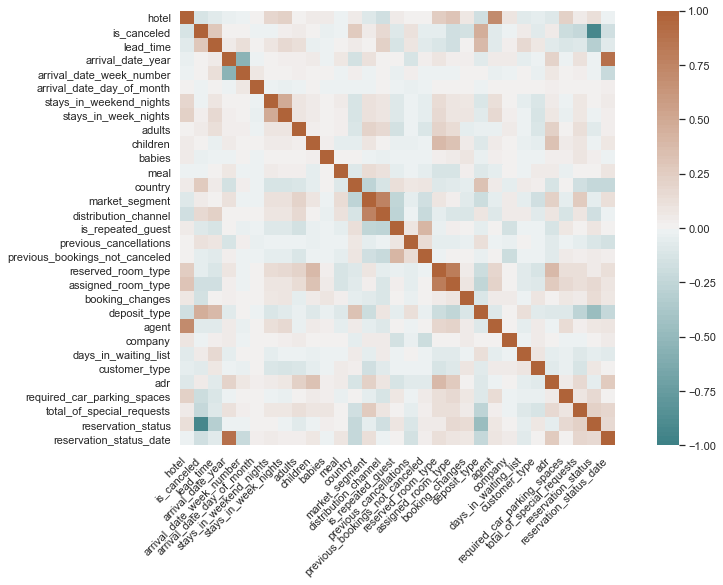

In [69]:
#Find the corelation between the variables
corr=booking_df_drop.corr()
sns.set(rc = {'figure.figsize':(15,8)})
ax=sns.heatmap(corr,vmin=-1,vmax=1,center=0,cmap=sns.diverging_palette(200,30,n=100),square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

In [70]:
#Drop irrelevent columns which are not needed
booking_df_drop.drop(['arrival_date_month', 'meal','customer_type', 'reservation_status', 'reservation_status_date'], axis = 1, inplace=True)

In [71]:
#Take only the columns needed to build the model into y and X variables
y = np.array(booking_df_drop['is_canceled'])
X = np.array(booking_df_drop[["hotel","lead_time","country","distribution_channel","previous_cancellations","assigned_room_type","booking_changes","required_car_parking_spaces","total_of_special_requests","deposit_type"]])

In [72]:
#Data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(89542, 10) (29848, 10) (89542,) (29848,)


In [73]:
#Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [74]:
#Run Logistic Regression
lg = LogisticRegression()
lg.fit(X_train,y_train)
pred_lg = lg.predict(X_test)
accuracy= accuracy_score(pred_lg,y_test)
print ('Accuracy : {:.2f}%'.format(accuracy*100))
MSE_lg=mean_squared_error(y_test,pred_lg)
RMSE_lg=math.sqrt(MSE_lg)
print("The RMSE value for Random Forest Classifier is:",RMSE_lg)
print("The coefficients are:", lg.coef_)

Accuracy : 77.24%
The RMSE value for Random Forest Classifier is: 0.47706020369791025
The coefficients are: [[-5.59938314e-02  3.19531223e-01  3.72245402e-01  3.80294117e-01
   8.06566530e-01 -2.54562530e-03 -2.77660072e-01 -2.81056289e+00
  -3.13399098e-01  1.20786041e+00]]


              precision    recall  f1-score   support

           0       0.75      0.96      0.84     18814
           1       0.86      0.46      0.60     11034

    accuracy                           0.77     29848
   macro avg       0.81      0.71      0.72     29848
weighted avg       0.79      0.77      0.75     29848

[[17983   831]
 [ 5962  5072]]


<AxesSubplot:>

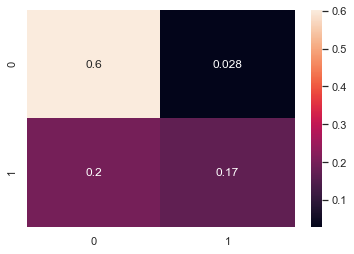

In [75]:
#Print the confusion Matrix
print(classification_report(y_test,pred_lg))
cf_matrix_lg = confusion_matrix(y_test, pred_lg)
print(cf_matrix_lg)
sns.set(rc = {'figure.figsize':(6,4)})
sns.heatmap(cf_matrix_lg/np.sum(cf_matrix_lg), annot=True)

In [76]:
#Run RandomForestClassifier model
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
acc_rfc = accuracy_score(pred_rfc, y_test)
print ('Accuracy : {:.2f}%'.format(acc_rfc*100))
MSE_rfc=mean_squared_error(y_test,pred_rfc)
RMSE_rfc=math.sqrt(MSE_rfc)
print("The RMSE value for Random Forest Classifier is:",RMSE_rfc)

Accuracy : 82.25%
The RMSE value for Random Forest Classifier is: 0.42134645248374636


              precision    recall  f1-score   support

           0       0.84      0.88      0.86     18814
           1       0.78      0.72      0.75     11034

    accuracy                           0.82     29848
   macro avg       0.81      0.80      0.81     29848
weighted avg       0.82      0.82      0.82     29848

[[16643  2171]
 [ 3128  7906]]


<AxesSubplot:>

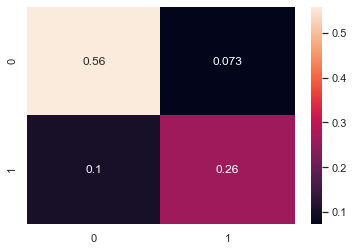

In [77]:
#Print the confusion matrix
print(classification_report(y_test,pred_rfc))
cf_matrix_rfc = confusion_matrix(y_test, pred_rfc)
print(cf_matrix_rfc)
sns.set(rc = {'figure.figsize':(6,4)})
sns.heatmap(cf_matrix_rfc/np.sum(cf_matrix_rfc), annot=True)

In [78]:
#Print the table with the model vs its accuracy
output = pd.DataFrame({"Model":['Logistic Regression','Random Forest Classifier'],
                      "Accuracy":[accuracy, acc_rfc]})
output

,Model,Accuracy
0,Logistic Regression,0.772414
1,Random Forest Classifier,0.822467


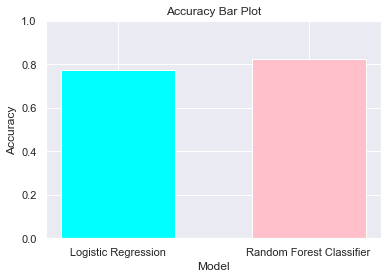

In [79]:
#Plot the barplot
plt.bar(output['Model'],output['Accuracy'],color=['aqua','pink'],width=0.6)
plt.ylim(0,1.0)
plt.ylabel('Accuracy')
plt.xlabel("Model")
plt.title('Accuracy Bar Plot')
plt.show()

In [80]:
# Converting string month to numerical one (Jan = 1, Feb = 2,... Dec = 12, etc.)
datetime_object = booking_df['arrival_date_month'].str[:]
month_number = np.zeros(len(datetime_object))

# Creating a new column based on numerical representation of the months
for i in range(0, len(datetime_object)):
    datetime_object[i] = datetime.datetime.strptime(datetime_object[i],"%B")
    month_number[i] = datetime_object[i].month

# Float to integer conversion
month_number = pd.DataFrame(month_number).astype(int)

booking_df['arrival_date'] = booking_df['arrival_date_year'].map(str) + '-' + month_number[0].map(str) + '-' \
                       + booking_df['arrival_date_day_of_month'].map(str)

booking_df['arrival_date'] = pd.to_datetime(booking_df['arrival_date'])
booking_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,87.0,189.0,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,87.0,189.0,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,87.0,189.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,304.0,189.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,189.0,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,394.0,189.0,0,Transient,96.14,0,0,Check-Out,2017-09-06,2017-08-30
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,9.0,189.0,0,Transient,225.43,0,2,Check-Out,2017-09-07,2017-08-31
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,9.0,189.0,0,Transient,157.71,0,4,Check-Out,2017-09-07,2017-08-31
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,89.0,189.0,0,Transient,104.40,0,0,Check-Out,2017-09-07,2017-08-31


In [81]:
# Calculating total guests for each record
booking_df['Total Guests'] = booking_df['adults'] + booking_df['children']
booking_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,Total Guests
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,189.0,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2.0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,189.0,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2.0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,189.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,1.0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,189.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,1.0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,189.0,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,189.0,0,Transient,96.14,0,0,Check-Out,2017-09-06,2017-08-30,2.0
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,189.0,0,Transient,225.43,0,2,Check-Out,2017-09-07,2017-08-31,3.0
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,189.0,0,Transient,157.71,0,4,Check-Out,2017-09-07,2017-08-31,2.0
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,189.0,0,Transient,104.40,0,0,Check-Out,2017-09-07,2017-08-31,2.0


In [82]:
# Creating two dataframes include only discrete hotel type
Resort_df = booking_df[booking_df['hotel'] == 'Resort Hotel']
City_df = booking_df[booking_df['hotel'] == 'City Hotel']

Resort_df=Resort_df.reset_index(drop=True)
City_df = City_df.reset_index(drop=True)

In [83]:
# Calculating Number of Guests Weekly - Resort Hotel
NumberOfGuests_Resort = Resort_df[['arrival_date', 'Total Guests']]
Resort_Guests_Weekly = Resort_df['Total Guests'].groupby(Resort_df['arrival_date']).sum().to_frame()
Resort_Guests_Weekly = Resort_Guests_Weekly.resample('w').sum()
Resort_Guests_Weekly

KeyboardInterrupt: 

In [ ]:
# Calculating Number of Guests Weekly - City Hotel
NumberOfGuests_City = City_df[['arrival_date', 'Total Guests']]
City_Guests_Weekly = City_df['Total Guests'].groupby(City_df['arrival_date']).sum().to_frame()
City_Guests_Weekly = City_Guests_Weekly.resample('w').sum()
City_Guests_Weekly

In [ ]:
#Auto ARIMA model for City Hotel to get p (AR), d (I) and q (MA) values for ARIMA model

trainCity = City_Guests_Weekly[:86]
testCity = City_Guests_Weekly[86:]

arima_fit_City = auto_arima(trainCity['Total Guests'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore', # we don't want to know if an order does not work
                          suppress_warnings=True, # we don't want convergence warnings
                          stepwise=True) # set to stepwise
print("Auto ARIMA for City Hotel")
arima_fit_City.summary()

In [ ]:
#Auto ARIMA model for Resort Hotel to get p (AR), d (I) and q (MA) values for ARIMA model

trainResort = Resort_Guests_Weekly[:86]
testResort = Resort_Guests_Weekly[86:]

arima_fit_Resort = auto_arima(trainResort['Total Guests'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore', # we don't want to know if an order does not work
                          suppress_warnings=True, # we don't want convergence warnings
                          stepwise=True) # set to stepwise
print("Auto ARIMA for Resort Hotel")
arima_fit_Resort.summary()

In [ ]:
#ARIMA model for time series forecasting for City Hotel


modelCity = ARIMA(trainCity['Total Guests'],order=(3, 0, 0),seasonal_order=(2, 1, 0, 12))
resultCity = modelCity.fit()

# Prediction of the Test data
prediction_City = resultCity.predict(86, 113, typ='levels').rename("Predictions")

#ARIMA model for time series forecasting for Resort Hotel


modelResort = ARIMA(trainResort['Total Guests'],order=(2, 0, 0),seasonal_order=(2, 1, 0, 12))
resultResort = modelResort.fit()

# Prediction of the Test data
prediction_Resort = resultResort.predict(86, 113, typ='levels').rename("Predictions")

In [ ]:
#No. of guests' prediction plot for City Hotel

plt.figure(figsize=(15, 8))
trainCity['Total Guests'].plot(legend=True)
prediction_City.plot(legend=True)
plt.title('Prediction of Number of Guests for City Hotel', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

MAPE_CityHotel = mean_absolute_percentage_error(testCity, prediction_City)
print('MAPE for City Hotel:{:.6f}'.format(MAPE_CityHotel))

In [ ]:
#No. of guests' prediction plot for Resort Hotel

plt.figure(figsize=(15, 8))
trainResort['Total Guests'].plot(legend=True)
prediction_Resort.plot(legend=True)
plt.title('Prediction of Number of Guests for Resort Hotel', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

MAPE_Resort_Hotel = mean_absolute_percentage_error(testResort, prediction_Resort)
print('MAPE for Resort Hotel:{:.6f}'.format(MAPE_Resort_Hotel))